In [104]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [105]:
from fastai.conv_learner import *


In [106]:
from fastai.imports import *
from fastai.transforms import *
from fastai.dataset import *
from sklearn.metrics import fbeta_score
import warnings

def f2(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return max([fbeta_score(targs, (preds>th), 2, average='samples')
                    for th in np.arange(start,end,step)])

def opt_th(preds, targs, start=0.17, end=0.24, step=0.01):
    ths = np.arange(start,end,step)
    idx = np.argmax([fbeta_score(targs, (preds>th), 2, average='samples')
                for th in ths])
    return ths[idx]


In [107]:
PATH = 'data/planet/'

In [108]:
ls {PATH}

__MACOSX/                     test-tif-v2.tar.7z            train-tif-v2/
models/                       test_v2_file_mapping.csv      train-tif-v2.tar.7z
sample_submission_v2.csv.zip  test_v2_file_mapping.csv.zip  train_v2.csv
test-jpg/                     tmp/                          train_v2.csv.zip
test-jpg-additional.tar.7z    train-jpg/
test-jpg.tar.7z               train-jpg.tar.7z


In [109]:
label_csv = f'{PATH}train_v2.csv'

In [110]:
label_df = pd.read_csv(label_csv)

In [111]:
label_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [113]:
metrics=[f2]

In [114]:
n = len(list(open(label_csv)))-1

In [115]:
val_idxs = get_cv_idxs(n)

In [116]:
get_cv_idxs

<function fastai.dataset.get_cv_idxs>

In [117]:
f_model = resnet34

In [118]:
#create a get data function that allows you to pass in a size
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH,'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [119]:
data = get_data(256)

In [120]:
iter(data.val_dl)

In [121]:
x,y = next(iter(data.val_dl))

In [122]:
y


    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
       ...          ⋱          ...       
    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     1
[torch.FloatTensor of size 64x17]

In [65]:
data.classes

['agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water']

In [123]:
y[0]


 1
 0
 0
 0
 0
 1
 0
 0
 0
 0
 0
 0
 1
 0
 0
 0
 1
[torch.FloatTensor of size 17]

In [124]:
list(zip(data.classes,y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

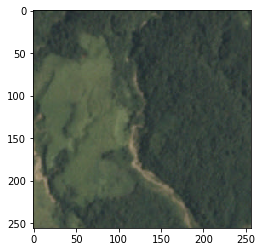

In [125]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]);

In [126]:
sz=64

In [127]:
data = get_data(sz)

In [128]:
data = data.resize(int(sz*1.4),'tmp')

A Jupyter Widget

In [130]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

In [131]:
lrf = learn.lr_find()

A Jupyter Widget

[ 0.       0.21705  0.30703  0.77977]                        



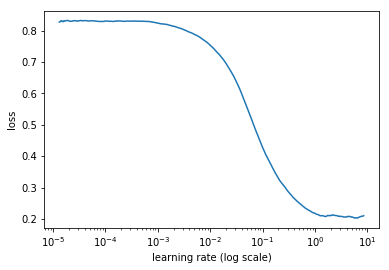

In [133]:
learn.sched.plot()

In [134]:
lr = 0.2

In [135]:
learn.fit(lr,3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.14724  0.1375   0.87588]                        
[ 1.       0.14354  0.13029  0.88286]                        
[ 2.       0.13456  0.12889  0.88476]                        
[ 3.       0.1374   0.12808  0.88489]                        
[ 4.       0.13216  0.12732  0.88568]                        
[ 5.       0.13267  0.12514  0.88845]                        
[ 6.       0.13065  0.12544  0.88764]                        

